In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import os
import random
import cv2
import ultralytics

import tensorflow as tf
from ultralytics import YOLO
from PIL import Image
import yaml
from collections import defaultdict

import albumentations as A
import shutil
from tqdm import tqdm

In [4]:
import torch

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
dir = "G:/My Drive/UAO/7° Semestre/IA Embebidos/proyecto_3/Trash"

In [7]:
with open(os.path.join(dir, "data.yaml"), 'r') as f:
  data_yaml = yaml.safe_load(f)
  class_names = data_yaml['names']
  num_classes = len(class_names)

In [8]:
print(class_names)
print(num_classes)

['Bateria', 'BotellaPlastico', 'BotellaVidrio', 'HojaPapel', 'TapaPlastico', 'TazaPapel']
6


## Lectura y validación de imágenes con su máscara 

In [9]:
def show_image_with_boxes(img_path, label_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w = img.shape[:2]

  fig, ax = plt.subplots(1)
  ax.imshow(img)

  with open(label_path, 'r') as f:
    for line in f.readlines():
      cls_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
      x_center *= w
      y_center *= h
      box_w *= w
      box_h *= h
      x1 = x_center - box_w / 2
      y1 = y_center - box_h / 2
      rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                                edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      ax.text(x1, y1 - 10, class_names[int(cls_id)],
              color='white', backgroundcolor='red', fontsize=8)
  plt.axis('off')
  plt.show()

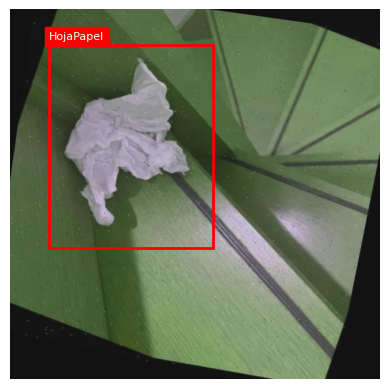

In [10]:
subsets = ['train', 'valid', 'test']

subset = subsets[0]
images_dir = os.path.join(dir, subset, 'images')
labels_dir = os.path.join(dir, subset, 'labels')

random_image = random.choice(os.listdir(images_dir))
img_path = os.path.join(images_dir, random_image)
label_path = os.path.join(labels_dir, random_image.replace('.jpg', '.txt').replace('.png', '.txt'))

show_image_with_boxes(img_path, label_path)

In [11]:
def count_boxes_per_class(base_path, sets):
  stats = {}

  for s in sets:
    labels_dir = os.path.join(base_path, s, 'labels')
    class_counts = defaultdict(int)

    for label_file in os.listdir(labels_dir):
      with open(os.path.join(labels_dir, label_file), 'r') as f:
        for line in f:
          cls_id = int(float(line.strip().split()[0]))
          class_counts[cls_id] += 1

    stats[s] = {class_names[k]: v for k, v in class_counts.items()}
  return stats

## Entrenamiento de modelo

In [12]:
model = YOLO('yolov8n.pt')

In [13]:
model.train(
  data= dir + '/data.yaml',
  epochs=600,
  imgsz=350,
  batch=16,
  workers=2,
  name='trash_yolov8n_640_v3',
  device=0  # Usa 'cpu' o '0' para GPU
)

New https://pypi.org/project/ultralytics/8.3.145 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=G:/My Drive/UAO/7 Semestre/IA Embebidos/proyecto_3/Trash/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=600, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=350, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals

100%|██████████| 5.35M/5.35M [00:01<00:00, 3.50MB/s]


AMP: checks passed 
WARNING imgsz=[350] must be multiple of max stride 32, updating to [352]
train: Fast image access  (ping: 34.273.9 ms, read: 4.01.7 MB/s, size: 62.3 KB)


train: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\train\labels.cache... 6392 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6392/6392 [00:00<?, ?it/s]

train: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\train\images\train_Image_93_png.rf.5e12f3faf71db62a649aa4d738d1a07f.jpg: 1 duplicate labels removed
train: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\train\images\train_Image_93_png.rf.e61c4247ceaaab2f5d286fc013c3abf6.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 1.00.1 ms, read: 7.05.4 MB/s, size: 65.1 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\valid\labels.cache... 1825 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1825/1825 [00:00<?, ?it/s]

val: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\valid\images\train_Image_93_png.rf.a9258ae990417389e348cc58616e37cf.jpg: 1 duplicate labels removed


Plotting labels to runs\detect\trash_yolov8n_640_v3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 352 train, 352 val
Using 2 dataloader workers
Logging results to runs\detect\trash_yolov8n_640_v3
Starting training for 600 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/600     0.857G      1.299      2.989      1.296         56        352: 100%|██████████| 400/400 [01:22<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.91it/s]


                   all       1825       6011      0.415      0.475      0.391      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/600      1.21G      1.309      1.881      1.287         32        352: 100%|██████████| 400/400 [00:52<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:10<00:00,  5.46it/s]


                   all       1825       6011      0.485      0.502      0.479      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/600      1.21G      1.381      1.829      1.312        134        352: 100%|██████████| 400/400 [00:51<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  5.22it/s]


                   all       1825       6011      0.405       0.45      0.401       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/600      1.21G       1.45       1.87      1.351         82        352: 100%|██████████| 400/400 [00:52<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:10<00:00,  5.50it/s]


                   all       1825       6011      0.486      0.443      0.418      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/600      1.21G      1.414      1.777      1.328         34        352: 100%|██████████| 400/400 [00:50<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:10<00:00,  5.35it/s]


                   all       1825       6011      0.509       0.51      0.494      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/600      1.21G      1.399      1.678       1.31         35        352: 100%|██████████| 400/400 [00:50<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:10<00:00,  5.49it/s]


                   all       1825       6011      0.575      0.525       0.54      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/600      1.21G      1.357        1.6      1.298         27        352: 100%|██████████| 400/400 [00:51<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  5.18it/s]


                   all       1825       6011      0.584      0.555       0.56      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/600      1.21G      1.347      1.515      1.281         23        352: 100%|██████████| 400/400 [01:03<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.86it/s]

                   all       1825       6011      0.647      0.576      0.611       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/600      1.21G      1.315      1.477      1.277         51        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.96it/s]

                   all       1825       6011      0.642      0.611      0.626      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/600      1.21G      1.294      1.413      1.256         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.95it/s]


                   all       1825       6011      0.557      0.641      0.619      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/600      1.21G      1.276      1.371      1.255         54        352: 100%|██████████| 400/400 [00:59<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  5.07it/s]


                   all       1825       6011      0.657      0.618      0.669      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/600      1.21G      1.262      1.331      1.243         74        352: 100%|██████████| 400/400 [01:11<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.87it/s]


                   all       1825       6011      0.682      0.648       0.66      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/600      1.21G      1.245      1.302      1.234         58        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.608      0.643      0.655      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/600      1.21G      1.248      1.271      1.236         56        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.689      0.674      0.692      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/600      1.21G      1.225      1.242      1.218         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.83it/s]

                   all       1825       6011      0.694      0.729       0.74      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/600      1.21G       1.22      1.221      1.216         59        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.97it/s]

                   all       1825       6011      0.722      0.721      0.738      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/600      1.21G      1.214      1.207      1.213         40        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.727      0.702      0.735      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/600      1.21G       1.21      1.188      1.209         55        352: 100%|██████████| 400/400 [01:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.90it/s]

                   all       1825       6011      0.707      0.718      0.743      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/600      1.21G      1.201      1.168      1.211         37        352: 100%|██████████| 400/400 [01:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  5.07it/s]

                   all       1825       6011        0.7      0.718      0.733       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/600      1.21G      1.187      1.145      1.199         23        352: 100%|██████████| 400/400 [00:55<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:10<00:00,  5.68it/s]

                   all       1825       6011      0.743      0.704      0.756      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/600      1.21G      1.183      1.135      1.197         47        352: 100%|██████████| 400/400 [00:52<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:10<00:00,  5.40it/s]

                   all       1825       6011      0.726      0.731      0.753      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/600      1.21G      1.167      1.128      1.197        126        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  5.87it/s]

                   all       1825       6011      0.734      0.725      0.765      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/600      1.21G      1.165      1.105      1.188         63        352: 100%|██████████| 400/400 [00:53<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  5.85it/s]

                   all       1825       6011      0.741      0.746      0.767      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/600      1.21G      1.158      1.082      1.181         32        352: 100%|██████████| 400/400 [00:59<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]

                   all       1825       6011      0.728      0.759      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/600      1.21G      1.166      1.083      1.189         52        352: 100%|██████████| 400/400 [00:57<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  5.83it/s]

                   all       1825       6011       0.73       0.76      0.774      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/600      1.21G      1.146      1.059      1.182         35        352: 100%|██████████| 400/400 [00:54<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.89it/s]

                   all       1825       6011      0.718       0.72      0.765      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/600      1.21G      1.136      1.056      1.177         53        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.757      0.727      0.772      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/600      1.21G      1.129      1.048      1.169         46        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.751      0.767       0.79       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/600      1.21G      1.134      1.039      1.169         33        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.88it/s]

                   all       1825       6011      0.743      0.768      0.795      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/600      1.21G      1.125      1.023      1.169         43        352: 100%|██████████| 400/400 [01:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.736      0.764      0.792      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/600      1.21G       1.12      1.011      1.163         27        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.85it/s]

                   all       1825       6011      0.753      0.761      0.793      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/600      1.21G      1.118      1.007      1.162         32        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011      0.767      0.771      0.796      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/600      1.21G      1.118      1.011      1.162        109        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.95it/s]

                   all       1825       6011      0.754      0.778      0.796      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/600      1.21G      1.108     0.9947      1.157         32        352: 100%|██████████| 400/400 [01:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.749      0.781      0.798      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/600      1.21G      1.101     0.9932      1.157        117        352: 100%|██████████| 400/400 [01:04<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.89it/s]

                   all       1825       6011      0.758      0.808      0.818      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/600      1.21G      1.087     0.9629      1.146         44        352: 100%|██████████| 400/400 [01:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.746      0.776      0.804      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/600      1.21G      1.096     0.9689      1.154         30        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.774      0.795      0.813      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/600      1.21G      1.096     0.9666      1.154         34        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.77      0.808      0.818      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/600      1.21G      1.089     0.9356      1.145         33        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]

                   all       1825       6011      0.782      0.812      0.831      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/600      1.21G      1.087     0.9575       1.15         42        352: 100%|██████████| 400/400 [01:03<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.737      0.819      0.818      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/600      1.21G      1.085     0.9433      1.148         32        352: 100%|██████████| 400/400 [01:03<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.769      0.812       0.82      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/600      1.21G       1.07      0.925       1.14         56        352: 100%|██████████| 400/400 [01:03<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.757      0.812      0.824      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/600      1.21G      1.067     0.9313      1.138         53        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.767      0.806      0.826      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/600      1.21G      1.072     0.9262      1.145         26        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.775      0.825      0.836      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/600      1.21G      1.069     0.9307      1.138         71        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.759      0.828      0.827      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/600      1.21G      1.061     0.9055      1.132        105        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011       0.78      0.822      0.835      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/600      1.21G      1.064     0.9123      1.134         52        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.771      0.825      0.833      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/600      1.21G      1.064     0.9113      1.129         81        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.776      0.823       0.83        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/600      1.21G      1.063     0.9119      1.137         76        352: 100%|██████████| 400/400 [01:03<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.771      0.831      0.839       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/600      1.21G      1.061      0.905      1.131         39        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.788      0.822      0.841      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/600      1.21G      1.055      0.891      1.127         48        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.787      0.825      0.844      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/600      1.21G      1.049     0.8879      1.127         76        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.788      0.833       0.85      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/600      1.21G      1.054     0.9054      1.135         59        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.781      0.834       0.84      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/600      1.21G      1.051     0.8914      1.128         59        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.793      0.828      0.847      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/600      1.21G       1.04     0.8713       1.12         22        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.795      0.846      0.849      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/600      1.21G      1.043     0.8834      1.123         50        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.799      0.838      0.854      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/600      1.21G      1.051     0.8867      1.131         73        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.796      0.844      0.856      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/600      1.21G      1.044      0.877      1.124         52        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.803      0.837       0.85      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/600      1.21G       1.04     0.8736      1.116         85        352: 100%|██████████| 400/400 [00:59<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.796      0.843      0.852      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/600      1.21G      1.035     0.8695       1.12         43        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011        0.8      0.846      0.854      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/600      1.21G      1.021     0.8528      1.114         57        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.796      0.849      0.854       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/600      1.21G       1.03     0.8588      1.121         49        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.791      0.868      0.859      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/600      1.21G      1.032     0.8581      1.114         30        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.797      0.856      0.857      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/600      1.21G      1.025     0.8516      1.114         30        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.799      0.861      0.862      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/600      1.21G      1.025     0.8463      1.112         66        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011        0.8      0.838      0.851      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/600      1.21G       1.02     0.8465      1.111         55        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011       0.79      0.871      0.859      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/600      1.21G      1.023     0.8526      1.116         76        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.85it/s]

                   all       1825       6011      0.806      0.862      0.867      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/600      1.21G      1.019     0.8438      1.113         30        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.797      0.865      0.864      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/600      1.21G      1.021     0.8397      1.107         25        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.804      0.852      0.861      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/600      1.21G      1.013     0.8324      1.105         33        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.798      0.867      0.864      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/600      1.21G      1.023     0.8336       1.11         53        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.806      0.871      0.866      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/600      1.21G      1.013     0.8318      1.105         67        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011      0.795      0.861      0.867       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/600      1.21G      1.016      0.837      1.109         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.805      0.875      0.869      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/600      1.21G      1.009     0.8177      1.105         29        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.81      0.867      0.862      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/600      1.21G      1.006     0.8168      1.102         73        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.802      0.874      0.864       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/600      1.21G      1.006      0.812      1.099         24        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.794      0.873      0.866      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/600      1.21G      1.002     0.8169        1.1         55        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.785      0.868      0.866       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/600      1.21G     0.9989     0.8038      1.095         63        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.797      0.871      0.868      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/600      1.21G          1     0.8236      1.103         51        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.799       0.88      0.871      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/600      1.21G     0.9982     0.8062      1.095         41        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.816      0.874      0.873      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/600      1.21G      1.005     0.8092      1.103         53        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.818      0.874      0.872      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/600      1.21G      1.001     0.8036      1.104         52        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.815       0.87      0.875       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/600      1.21G     0.9935     0.8094      1.099         36        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.804      0.878       0.87      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/600      1.21G     0.9932     0.8024      1.098         33        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.799      0.883      0.871      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/600      1.21G     0.9938      0.797      1.095         39        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.801      0.876      0.871      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/600      1.21G     0.9928     0.8118      1.093         35        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.812      0.876      0.871      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/600      1.21G     0.9869     0.7965      1.094         28        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.802      0.877       0.87      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/600      1.21G     0.9764     0.7853      1.092         61        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.814       0.87      0.867      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/600      1.21G     0.9822     0.7913       1.09         44        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011       0.82       0.87      0.871      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/600      1.21G     0.9897     0.7997      1.097         23        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011       0.81      0.868      0.867       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/600      1.21G      0.991     0.7935      1.096         37        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.813      0.868       0.87      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/600      1.21G     0.9767     0.7912      1.096         43        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011      0.818      0.867      0.871      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/600      1.21G     0.9681      0.778      1.087         92        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.824      0.874      0.875      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/600      1.21G      0.986     0.7877      1.093        111        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.813      0.879      0.878      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/600      1.21G     0.9771     0.7848      1.087         36        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.818      0.876       0.88      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/600      1.21G     0.9848     0.7839      1.092         58        352: 100%|██████████| 400/400 [00:59<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.821      0.877      0.879      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/600      1.21G      0.976     0.7746      1.089         33        352: 100%|██████████| 400/400 [00:59<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.818      0.877      0.879      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/600      1.21G      0.972     0.7793      1.084         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.816      0.882      0.882      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/600      1.21G     0.9734     0.7755      1.089         37        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.822      0.881      0.883      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/600      1.21G      0.975     0.7821      1.091         52        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.826       0.88      0.883      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/600      1.21G     0.9684     0.7732      1.089         71        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.86it/s]

                   all       1825       6011      0.824      0.883      0.882      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/600      1.21G      0.973     0.7723      1.085         38        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.824      0.882      0.881      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/600      1.21G     0.9723     0.7789      1.087         36        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.87it/s]

                   all       1825       6011      0.827      0.879      0.881      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/600      1.21G     0.9708     0.7717      1.085         40        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.822      0.885       0.88      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/600      1.21G     0.9672     0.7616      1.086         37        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.821      0.883      0.879      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/600      1.21G     0.9634     0.7603      1.079         34        352: 100%|██████████| 400/400 [01:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.822      0.883       0.88      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/600      1.21G      0.972     0.7556      1.083         48        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.828       0.88      0.881      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/600      1.21G     0.9669     0.7567      1.076         72        352: 100%|██████████| 400/400 [00:59<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.825       0.88      0.882      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/600      1.21G     0.9584     0.7579      1.079         70        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.826      0.881      0.882      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/600      1.21G       0.96     0.7678       1.08         31        352: 100%|██████████| 400/400 [01:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.829      0.879      0.882       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/600      1.21G     0.9629     0.7643       1.08         48        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.831      0.881      0.882       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/600      1.21G     0.9585     0.7569      1.079         16        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011       0.83      0.875      0.882       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/600      1.21G     0.9649     0.7515      1.077         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011       0.83      0.877      0.882       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/600      1.21G     0.9499     0.7483      1.072         26        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.826      0.879      0.882      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/600      1.21G     0.9667     0.7608      1.078        129        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.823       0.88      0.882      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/600      1.21G     0.9502     0.7485      1.071         50        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.823      0.885      0.883      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/600      1.21G     0.9528     0.7539      1.073         43        352: 100%|██████████| 400/400 [01:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.824      0.885      0.883      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/600      1.21G     0.9541     0.7381      1.076         39        352: 100%|██████████| 400/400 [01:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.825      0.884      0.883       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/600      1.21G     0.9502     0.7454      1.072         25        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.822      0.889      0.883      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/600      1.21G      0.948     0.7432      1.071         69        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.822      0.883      0.883      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/600      1.21G     0.9527     0.7492      1.075         46        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.823      0.883      0.884      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/600      1.21G     0.9477     0.7374      1.075         56        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.827      0.884      0.884      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/600      1.21G     0.9633     0.7474      1.081         40        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.825      0.884      0.884      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/600      1.21G     0.9521     0.7399      1.072         48        352: 100%|██████████| 400/400 [01:04<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.88it/s]

                   all       1825       6011      0.825      0.885      0.884      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/600      1.21G     0.9515     0.7487      1.072         36        352: 100%|██████████| 400/400 [01:03<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.823      0.886      0.884      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/600      1.21G     0.9465     0.7319      1.068         49        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.828      0.884      0.884      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/600      1.21G     0.9487     0.7384      1.071         42        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.89it/s]

                   all       1825       6011      0.829      0.883      0.885      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/600      1.21G     0.9412     0.7278      1.067         25        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.827      0.883      0.885      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/600      1.21G     0.9378     0.7268      1.067         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.829      0.883      0.885      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/600      1.21G      0.932     0.7266      1.069         50        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.832       0.88      0.885      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/600      1.21G     0.9399     0.7346      1.071         27        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.833      0.879      0.885      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/600      1.21G     0.9399     0.7271      1.072         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.832       0.88      0.885      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/600      1.21G      0.941      0.736      1.069         74        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.828      0.884      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/600      1.21G     0.9326     0.7221      1.072         67        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.827      0.882      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/600      1.21G     0.9469     0.7341      1.072         34        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.831       0.88      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/600      1.21G      0.936     0.7251      1.064         42        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.95it/s]

                   all       1825       6011      0.825      0.886      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/600      1.21G     0.9445     0.7231      1.073         47        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.83      0.886      0.886      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/600      1.21G     0.9291     0.7126      1.062         59        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.832      0.883      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/600      1.21G     0.9416     0.7239      1.069         59        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.832      0.885      0.885      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/600      1.21G      0.939     0.7206      1.066        110        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.831      0.885      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/600      1.21G      0.931     0.7182      1.064         27        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.829      0.889      0.885      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/600      1.21G     0.9336     0.7204      1.062        106        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011       0.83      0.891      0.886      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/600      1.21G      0.943     0.7285       1.07         32        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.829       0.89      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/600      1.21G     0.9449     0.7337      1.073         55        352: 100%|██████████| 400/400 [00:59<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.831      0.891      0.886       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/600      1.21G     0.9264     0.7123      1.061        125        352: 100%|██████████| 400/400 [00:59<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.831      0.892      0.886       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/600      1.21G     0.9355     0.7181      1.068         56        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.832       0.89      0.886       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/600      1.21G     0.9403     0.7104      1.063         71        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.833      0.889      0.886       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/600      1.21G     0.9304     0.7152      1.068         43        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.834      0.888      0.886      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/600      1.21G       0.93     0.7121      1.061         45        352: 100%|██████████| 400/400 [00:59<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.831      0.889      0.886      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/600      1.21G     0.9289     0.7161      1.065         72        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.833      0.888      0.887      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/600      1.21G     0.9334     0.7123      1.064         41        352: 100%|██████████| 400/400 [00:59<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.834      0.888      0.887      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/600      1.21G     0.9233     0.7084      1.061         51        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.88it/s]

                   all       1825       6011      0.834      0.888      0.887      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/600      1.21G     0.9269     0.7106      1.066         60        352: 100%|██████████| 400/400 [01:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.834      0.886      0.887      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/600      1.21G     0.9313      0.713      1.061         42        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.837      0.886      0.887      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/600      1.21G     0.9286     0.7094      1.061         41        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.835      0.888      0.888      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/600      1.21G     0.9309     0.7111      1.064         25        352: 100%|██████████| 400/400 [00:59<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.833      0.888      0.888      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/600      1.21G     0.9145     0.7102      1.061         32        352: 100%|██████████| 400/400 [00:59<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.833      0.888      0.888      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/600      1.21G     0.9231     0.7047      1.059         31        352: 100%|██████████| 400/400 [00:59<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.87it/s]

                   all       1825       6011      0.833      0.888      0.888      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/600      1.21G      0.915     0.7099      1.066         36        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.831       0.89      0.888      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/600      1.21G     0.9166      0.705       1.06         40        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.831       0.89      0.888      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/600      1.21G     0.9275     0.7067      1.063         40        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.831      0.891      0.889      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/600      1.21G     0.9111     0.6888      1.056         22        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.831      0.891      0.889      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/600      1.21G     0.9319     0.7113      1.064         29        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.831       0.89      0.889      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/600      1.21G     0.9171     0.7033      1.058         29        352: 100%|██████████| 400/400 [00:59<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011       0.83      0.892      0.889      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/600      1.21G     0.9143     0.6978      1.056         46        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.829      0.893      0.888      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/600      1.21G     0.9098     0.6908      1.057         56        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011       0.83      0.894      0.888      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/600      1.21G      0.919      0.697      1.058         54        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.831      0.893      0.888      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/600      1.21G     0.9144     0.7065      1.059         25        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.832      0.893      0.888      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/600      1.21G     0.9201     0.7025       1.06         50        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.833      0.892      0.888      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/600      1.21G      0.915     0.6956      1.056         41        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.833      0.891      0.888      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/600      1.21G      0.914     0.6936      1.058         43        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.835       0.89      0.888      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/600      1.21G     0.9101     0.6947      1.053         69        352: 100%|██████████| 400/400 [01:04<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.86it/s]

                   all       1825       6011      0.834      0.891      0.889      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/600      1.21G      0.914     0.6987      1.053         58        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.834      0.891      0.889      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/600      1.21G     0.9139     0.6891      1.056         41        352: 100%|██████████| 400/400 [00:53<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  5.90it/s]

                   all       1825       6011      0.834      0.891      0.889      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/600      1.21G     0.9132       0.69      1.055         37        352: 100%|██████████| 400/400 [00:52<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  6.16it/s]

                   all       1825       6011      0.834      0.894      0.889      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/600      1.21G     0.9161     0.6969      1.055         31        352: 100%|██████████| 400/400 [00:54<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.835      0.894      0.889      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/600      1.21G      0.904     0.6908      1.052         57        352: 100%|██████████| 400/400 [00:59<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.834      0.895      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/600      1.21G     0.9081     0.6869      1.055         43        352: 100%|██████████| 400/400 [00:59<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.84it/s]

                   all       1825       6011      0.836      0.894      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/600      1.21G     0.9086     0.6848      1.052         26        352: 100%|██████████| 400/400 [00:59<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.835      0.895      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/600      1.21G     0.9001     0.6866      1.048         91        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011      0.835      0.894      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/600      1.21G     0.9113     0.6904      1.054        131        352: 100%|██████████| 400/400 [01:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.834      0.895      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/600      1.21G     0.9021     0.6757      1.053         35        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.836      0.895      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/600      1.21G     0.9178     0.6909      1.055         24        352: 100%|██████████| 400/400 [00:59<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.836      0.893      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/600      1.21G     0.9015      0.678      1.051         29        352: 100%|██████████| 400/400 [00:59<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.836      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/600      1.21G     0.9017     0.6872      1.049         44        352: 100%|██████████| 400/400 [00:58<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.835      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/600      1.21G      0.903     0.6782       1.05         36        352: 100%|██████████| 400/400 [00:59<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.42it/s]

                   all       1825       6011      0.837       0.89      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/600      1.21G     0.9021     0.6864      1.047         52        352: 100%|██████████| 400/400 [01:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.43it/s]

                   all       1825       6011      0.836      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/600      1.21G     0.9022     0.6798      1.051         24        352: 100%|██████████| 400/400 [01:03<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.45it/s]

                   all       1825       6011      0.837      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/600      1.21G     0.9052     0.6861      1.051         55        352: 100%|██████████| 400/400 [01:16<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]

                   all       1825       6011      0.837      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/600      1.21G     0.8985     0.6775      1.046         64        352: 100%|██████████| 400/400 [00:58<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.838      0.891      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/600      1.21G     0.9012     0.6751      1.049         34        352: 100%|██████████| 400/400 [01:09<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.838      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/600      1.21G     0.8959     0.6768      1.045         64        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.838      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/600      1.21G     0.9067     0.6862      1.051         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.838      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/600      1.21G     0.8964     0.6788      1.053         78        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.838      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/600      1.21G     0.8975       0.68      1.047         20        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.837      0.893      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/600      1.21G     0.9066     0.6837      1.051         34        352: 100%|██████████| 400/400 [01:13<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.837      0.893      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/600      1.21G     0.9012      0.678      1.049        169        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.837      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/600      1.21G     0.8954     0.6768      1.048         23        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.838      0.893      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/600      1.21G     0.8951     0.6716      1.047        110        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.837      0.892      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/600      1.21G     0.8953     0.6798      1.047         18        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.838      0.892      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/600      1.21G     0.8867     0.6664      1.048         39        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.836      0.892      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/600      1.21G     0.8898     0.6793      1.046         43        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.835      0.894      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/600      1.21G      0.893      0.678      1.049         34        352: 100%|██████████| 400/400 [01:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.835      0.894      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/600      1.21G     0.8957     0.6689      1.047         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.835      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/600      1.21G     0.8843     0.6627      1.043         46        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.835      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/600      1.21G     0.8912     0.6651      1.042        106        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.837      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/600      1.21G     0.8933     0.6688      1.048         21        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.94it/s]

                   all       1825       6011      0.837      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/600      1.21G      0.889     0.6796      1.043         28        352: 100%|██████████| 400/400 [01:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.92it/s]

                   all       1825       6011      0.836      0.894      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/600      1.21G     0.8902     0.6705      1.047         50        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.84it/s]

                   all       1825       6011      0.838      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/600      1.21G     0.8926     0.6728      1.044         75        352: 100%|██████████| 400/400 [00:59<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.86it/s]

                   all       1825       6011      0.837      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/600      1.21G     0.8871     0.6662      1.042         78        352: 100%|██████████| 400/400 [00:59<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.838      0.894      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/600      1.21G     0.8948     0.6721      1.045         41        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.839      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/600      1.21G     0.8858     0.6609      1.041         37        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.839      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/600      1.21G     0.8879     0.6618      1.045         39        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.84it/s]

                   all       1825       6011      0.839      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/600      1.21G     0.8988     0.6677      1.045         40        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011       0.84      0.893      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/600      1.21G     0.8969     0.6673      1.042         51        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.841      0.893      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/600      1.21G     0.8787     0.6598      1.041         48        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011       0.84      0.893      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/600      1.21G     0.8809     0.6592       1.04         53        352: 100%|██████████| 400/400 [01:10<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.839      0.894      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/600      1.21G     0.8717     0.6557      1.037         75        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.839      0.894      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/600      1.21G     0.8841     0.6701      1.041         28        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.839      0.894      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/600      1.21G     0.8815      0.656      1.046         20        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011       0.84      0.893      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/600      1.21G      0.886     0.6581      1.041         41        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.839      0.894      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/600      1.21G     0.8738     0.6464      1.037         36        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.839      0.894      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/600      1.21G     0.8768     0.6475      1.038         29        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.839      0.895      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/600      1.21G     0.8898     0.6555      1.037         30        352: 100%|██████████| 400/400 [01:03<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]

                   all       1825       6011       0.84      0.895      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/600      1.21G     0.8792     0.6419      1.037         30        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011       0.84      0.895      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/600      1.21G      0.874     0.6573      1.035         37        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011       0.84      0.895      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/600      1.21G     0.8787      0.653      1.038         43        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.839      0.895      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/600      1.21G     0.8794     0.6569      1.041         59        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011       0.84      0.895      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/600      1.21G     0.8672     0.6614      1.032         27        352: 100%|██████████| 400/400 [01:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.84      0.895      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/600      1.21G     0.8763     0.6539      1.035         51        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011       0.84      0.895      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/600      1.21G     0.8747     0.6553      1.038         48        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.842      0.894      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/600      1.21G     0.8749     0.6504      1.037         49        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.841      0.894      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/600      1.21G     0.8852     0.6502      1.038         46        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.842      0.894      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/600      1.21G     0.8788     0.6486      1.036         99        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.841      0.895      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/600      1.21G     0.8683     0.6467      1.035         38        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.842      0.895      0.889      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/600      1.21G      0.863     0.6366      1.033         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.842      0.895      0.889      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/600      1.21G     0.8713     0.6529       1.04         44        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.842      0.894      0.889      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/600      1.21G     0.8755     0.6473      1.036         34        352: 100%|██████████| 400/400 [01:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.90it/s]

                   all       1825       6011      0.843      0.894      0.889      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/600      1.21G     0.8781     0.6625       1.04         52        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.843      0.894       0.89      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/600      1.21G     0.8605     0.6415      1.033         54        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.843      0.894       0.89      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/600      1.21G     0.8701     0.6404      1.032         85        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.843      0.893       0.89      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/600      1.21G     0.8578     0.6379      1.029         21        352: 100%|██████████| 400/400 [00:59<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.843      0.893       0.89      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/600      1.21G      0.867     0.6431      1.033         44        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.844      0.893       0.89      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/600      1.21G     0.8651      0.643       1.03         83        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.843      0.894       0.89      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/600      1.21G     0.8634     0.6409      1.032         92        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.843      0.895       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/600      1.21G     0.8786     0.6393      1.035         55        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.843      0.895       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/600      1.21G     0.8748     0.6508      1.034         42        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.844      0.895       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/600      1.21G     0.8646      0.641       1.03         57        352: 100%|██████████| 400/400 [01:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.844      0.894       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/600      1.21G     0.8537     0.6362       1.03         78        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.843      0.895       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/600      1.21G     0.8697     0.6465      1.032        128        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.843      0.894       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/600      1.21G     0.8746     0.6407      1.035         76        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.843      0.895       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/600      1.21G     0.8559     0.6331      1.033         34        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.843      0.895       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/600      1.21G     0.8664     0.6454      1.035         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.843      0.894       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/600      1.21G     0.8717      0.643      1.033         24        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.843      0.894       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/600      1.21G     0.8628      0.644      1.031         36        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.84it/s]

                   all       1825       6011      0.843      0.894       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/600      1.21G     0.8623     0.6378      1.031         25        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.844      0.895       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/600      1.21G     0.8588     0.6323      1.035         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.843      0.894       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/600      1.21G     0.8526     0.6277      1.027         86        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.844      0.894       0.89      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/600      1.21G     0.8529     0.6304      1.025         42        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.843      0.894      0.891      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/600      1.21G     0.8679     0.6342       1.03         40        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.844      0.894      0.891      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/600      1.21G     0.8481     0.6331      1.021         69        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.844      0.894      0.891      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/600      1.21G     0.8644     0.6387      1.032         31        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.844      0.894      0.891      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/600      1.21G     0.8528     0.6305      1.029        115        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.844      0.894      0.891      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/600      1.21G     0.8581     0.6276      1.026         30        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.844      0.894      0.891      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/600      1.21G       0.86     0.6345       1.03         19        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.843      0.895      0.891      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/600      1.21G     0.8611     0.6339      1.026         40        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.843      0.894       0.89      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/600      1.21G     0.8627     0.6344      1.033         36        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.844      0.895       0.89      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/600      1.21G     0.8542     0.6287      1.027        146        352: 100%|██████████| 400/400 [01:04<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.843      0.895      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/600      1.21G     0.8593     0.6327      1.028         36        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.844      0.894      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/600      1.21G     0.8511      0.626      1.029         73        352: 100%|██████████| 400/400 [01:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.84it/s]

                   all       1825       6011      0.843      0.894      0.891      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/600      1.21G     0.8682     0.6351      1.032        112        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.843      0.894      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/600      1.21G     0.8592     0.6313      1.022         78        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.844      0.895      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/600      1.21G     0.8496     0.6199      1.024         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.843      0.894      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/600      1.21G     0.8531     0.6271      1.027         40        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.844      0.894      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/600      1.21G     0.8533      0.626      1.027         66        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011      0.844      0.895      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/600      1.21G     0.8494     0.6253      1.025         76        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.843      0.894      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/600      1.21G     0.8614     0.6293      1.031         27        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.843      0.895      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/600      1.21G     0.8573     0.6237      1.027         63        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.844      0.896      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/600      1.21G     0.8586      0.624      1.029         45        352: 100%|██████████| 400/400 [01:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.843      0.896      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/600      1.21G     0.8458     0.6207      1.024         48        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.843      0.896      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/600      1.21G     0.8551     0.6182      1.026         19        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.85it/s]

                   all       1825       6011      0.844      0.895      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/600      1.21G      0.857     0.6262      1.026         37        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.844      0.895      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/600      1.21G     0.8434     0.6219      1.022         39        352: 100%|██████████| 400/400 [01:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.844      0.895       0.89      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/600      1.21G      0.843     0.6253      1.028         43        352: 100%|██████████| 400/400 [01:11<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.843      0.895      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/600      1.21G     0.8578     0.6215      1.028         50        352: 100%|██████████| 400/400 [01:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.844      0.895       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/600      1.21G     0.8526     0.6188      1.028         44        352: 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.844      0.895      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/600      1.21G     0.8416     0.6165      1.025         69        352: 100%|██████████| 400/400 [01:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.844      0.895       0.89      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/600      1.21G     0.8537     0.6228      1.027         55        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:11<00:00,  4.84it/s]

                   all       1825       6011      0.843      0.896      0.891      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/600      1.21G     0.8492     0.6162      1.026         51        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.843      0.896       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/600      1.21G     0.8441     0.6115      1.023        103        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.843      0.896       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/600      1.21G     0.8458      0.614      1.024         35        352: 100%|██████████| 400/400 [01:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.844      0.895       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/600      1.21G     0.8334     0.6115      1.021         58        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.81it/s]

                   all       1825       6011      0.843      0.896       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/600      1.21G     0.8414      0.616      1.021         83        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.842      0.898      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/600      1.21G     0.8361     0.6093      1.021         70        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.841      0.899      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/600      1.21G     0.8411     0.6131      1.022         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.841      0.899      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/600      1.21G     0.8436     0.6112      1.019         75        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.842      0.898      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/600      1.21G     0.8462     0.6168      1.022         40        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.844      0.896       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/600      1.21G     0.8349     0.6094      1.019         68        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.843      0.896      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/600      1.21G     0.8443     0.6189      1.025         41        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.843      0.896      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/600      1.21G     0.8376     0.6127      1.023         84        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.842      0.897      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/600      1.21G     0.8446     0.6152      1.025         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.842      0.897      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/600      1.21G       0.84     0.6065      1.022         61        352: 100%|██████████| 400/400 [01:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.842      0.897      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/600      1.21G     0.8387     0.6175      1.024         40        352: 100%|██████████| 400/400 [01:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.842      0.897      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/600      1.21G     0.8371     0.6085      1.017         37        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.842      0.897      0.891      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/600      1.21G     0.8442     0.6111      1.024         65        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.841      0.898      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/600      1.21G     0.8419     0.6112      1.023         28        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.841      0.898       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/600      1.21G     0.8406     0.6095      1.018         67        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.843      0.896       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/600      1.21G      0.833     0.6047      1.017         35        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.843      0.897       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/600      1.21G     0.8336     0.6064      1.021         61        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]

                   all       1825       6011      0.843      0.897       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/600      1.21G     0.8324     0.6048      1.019         51        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.843      0.897       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/600      1.21G     0.8355     0.6082      1.018         52        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.843      0.897       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/600      1.21G     0.8262     0.6051      1.017         54        352: 100%|██████████| 400/400 [01:03<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011      0.843      0.897      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/600      1.21G     0.8349     0.6031      1.018         45        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.843      0.896       0.89      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/600      1.21G     0.8385     0.6071      1.018        111        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.843      0.897      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/600      1.21G     0.8362     0.6088      1.016         57        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]

                   all       1825       6011      0.843      0.897       0.89      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/600      1.21G     0.8279     0.6035      1.016         39        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.843      0.897      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/600      1.21G     0.8307     0.6015      1.014         71        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.843      0.896      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/600      1.21G      0.837     0.6071      1.017         43        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.843      0.896      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/600      1.21G     0.8336     0.6066      1.016         83        352: 100%|██████████| 400/400 [01:04<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.843      0.897       0.89      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/600      1.21G     0.8254     0.5982      1.015         46        352: 100%|██████████| 400/400 [01:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.842      0.897       0.89      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/600      1.21G     0.8247     0.5999      1.013         31        352: 100%|██████████| 400/400 [01:03<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.844      0.896      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/600      1.21G     0.8228     0.5975      1.014         49        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.844      0.896      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/600      1.21G     0.8269     0.6033      1.018         78        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.843      0.897      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/600      1.21G     0.8219     0.5948      1.017         42        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.843      0.897      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/600      1.21G     0.8332     0.6029      1.014         23        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.843      0.898      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/600      1.21G     0.8288     0.6022      1.016         75        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.843      0.898      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/600      1.21G     0.8285     0.6007      1.017         52        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]

                   all       1825       6011      0.842      0.901      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/600      1.21G     0.8301      0.607      1.019         82        352: 100%|██████████| 400/400 [01:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.843      0.898      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/600      1.21G     0.8248     0.6031      1.011         54        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.843      0.898      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/600      1.21G      0.829     0.6002      1.015         43        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.842      0.899      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/600      1.21G     0.8299     0.5959      1.018         22        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.842      0.898      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/600      1.21G     0.8284     0.5958      1.016         43        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.844      0.897      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/600      1.21G     0.8213     0.5892      1.015         63        352: 100%|██████████| 400/400 [01:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.843      0.897      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/600      1.21G      0.826     0.5997      1.014         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.842      0.898      0.891      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/600      1.21G     0.8228     0.5912      1.014         28        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.843      0.898      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/600      1.21G     0.8245     0.5975      1.016         93        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.842      0.899      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/600      1.21G     0.8244     0.5988      1.013         36        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.843      0.899      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/600      1.21G      0.826     0.5967      1.016         33        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.842      0.899      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/600      1.21G     0.8224     0.5928      1.014         56        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.843      0.899      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/600      1.21G     0.8254     0.5922      1.014         30        352: 100%|██████████| 400/400 [01:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.843      0.899      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/600      1.21G     0.8239     0.5911      1.016         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.843      0.899      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/600      1.21G     0.8219     0.5827       1.01         28        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011      0.844      0.898      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/600      1.21G     0.8159     0.5843      1.012         94        352: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.844      0.897      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/600      1.21G     0.8134     0.5862      1.006         43        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.844      0.897      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/600      1.21G     0.8174     0.5927      1.008         61        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.844      0.897      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/600      1.21G      0.814     0.5762      1.006         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.843      0.897      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/600      1.21G     0.8205     0.5888      1.011         46        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.844      0.897      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/600      1.21G     0.8112     0.5887      1.007         37        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.844      0.896      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/600      1.21G     0.8094     0.5839      1.009         64        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.82it/s]

                   all       1825       6011      0.846      0.895      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/600      1.21G     0.8211     0.5954      1.013         27        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.845      0.895      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/600      1.21G      0.812      0.586      1.009         36        352: 100%|██████████| 400/400 [01:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.845      0.896      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/600      1.21G     0.8045     0.5771      1.005         37        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.846      0.895      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/600      1.21G     0.8169     0.5855      1.009         43        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.847      0.894      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/600      1.21G     0.8071     0.5816      1.009         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.847      0.894      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/600      1.21G     0.8074     0.5758      1.007         23        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.847      0.895      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/600      1.21G     0.8059      0.583      1.005         29        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.848      0.894      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/600      1.21G     0.8068     0.5784      1.009         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.848      0.893      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/600      1.21G     0.8144     0.5877      1.007         75        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.848      0.893      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/600      1.21G     0.8048     0.5733      1.005         48        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.848      0.894      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/600      1.21G     0.8049     0.5837      1.006         39        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011      0.848      0.893      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/600      1.21G     0.8099     0.5839      1.006         39        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.848      0.895      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/600      1.21G     0.8159     0.5839      1.005        101        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.848      0.895      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/600      1.21G     0.8025     0.5793      1.003         47        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.848      0.894      0.891      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/600      1.21G     0.8179     0.5847      1.008         70        352: 100%|██████████| 400/400 [01:10<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.848      0.895      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/600      1.21G     0.8139      0.579       1.01         61        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011      0.847      0.896      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/600      1.21G      0.803     0.5751      1.008        111        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.847      0.896      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/600      1.21G     0.8041     0.5783      1.004         65        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.847      0.896      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/600      1.21G     0.8007     0.5753      1.005        101        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.847      0.896      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/600      1.21G     0.8001     0.5706      1.001         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.846      0.896      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/600      1.21G     0.8002      0.573      1.004         29        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.846      0.896      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/600      1.21G     0.8063     0.5759      1.003         43        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.846      0.896      0.891       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/600      1.21G     0.8071     0.5744      1.003         42        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.847      0.896      0.891      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/600      1.21G     0.8094     0.5875      1.004         50        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.846      0.896      0.891      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/600      1.21G     0.8044     0.5733      1.001         54        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.846      0.896      0.891      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/600      1.21G     0.7963     0.5758      1.001         33        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]

                   all       1825       6011      0.846      0.896      0.891      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/600      1.21G     0.8009     0.5743     0.9993         43        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.57it/s]

                   all       1825       6011      0.846      0.896       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/600      1.21G     0.7966     0.5733      1.004         21        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.846      0.896       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/600      1.21G      0.798     0.5676     0.9997         57        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.846      0.896       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/600      1.21G     0.7988      0.566      1.001        119        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.846      0.896       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/600      1.21G     0.7985     0.5765      1.004         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.846      0.896       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/600      1.21G      0.801     0.5727      1.005         33        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]

                   all       1825       6011      0.846      0.896       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/600      1.21G     0.7911      0.564     0.9985         26        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.846      0.896       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/600      1.21G     0.8064     0.5687      1.004         36        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.847      0.895       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/600      1.21G     0.7903      0.566     0.9989         45        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.847      0.895       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/600      1.21G      0.795      0.561          1         48        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.848      0.894       0.89      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/600      1.21G     0.7986     0.5663      1.002         48        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.848      0.895      0.891      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/600      1.21G     0.7938     0.5633          1         58        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.848      0.894      0.891      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/600      1.21G      0.785     0.5653     0.9989         33        352: 100%|██████████| 400/400 [01:10<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.847      0.894      0.891      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/600      1.21G     0.8012     0.5724      1.003         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.848      0.894       0.89      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/600      1.21G     0.7828     0.5548     0.9968         41        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.847      0.894      0.891      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/600      1.21G     0.7948     0.5652      1.005         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.847      0.894      0.891      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/600      1.21G     0.7956     0.5675      1.004         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.847      0.894       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/600      1.21G     0.7935     0.5691     0.9986        119        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.847      0.894       0.89      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/600      1.21G     0.7941     0.5589     0.9967         33        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.847      0.894       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/600      1.21G     0.7963     0.5688     0.9981         45        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.847      0.893       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/600      1.21G     0.7926     0.5631     0.9967         58        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.847      0.894      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/600      1.21G     0.7935     0.5646     0.9971         54        352: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.847      0.894       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    399/600      1.21G     0.7931     0.5702     0.9979         25        352: 100%|██████████| 400/400 [01:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.848      0.894      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    400/600      1.21G     0.7916     0.5605     0.9981         54        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.848      0.893       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    401/600      1.21G     0.7923     0.5571     0.9974         68        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.55it/s]

                   all       1825       6011      0.848      0.893       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    402/600      1.21G     0.7863     0.5575     0.9947         51        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.848      0.892       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    403/600      1.21G     0.7867     0.5509     0.9961         45        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.80it/s]

                   all       1825       6011      0.849      0.892      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    404/600      1.21G     0.7907     0.5618      0.997         55        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.849      0.892       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    405/600      1.21G     0.7775     0.5557     0.9932         37        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.849      0.893      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    406/600      1.21G     0.7891     0.5597     0.9928         26        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]

                   all       1825       6011      0.849      0.893      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    407/600      1.21G     0.7805      0.551      0.991         40        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.849      0.892      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    408/600      1.21G     0.7831     0.5589     0.9986         26        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.848      0.893      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    409/600      1.21G     0.7819     0.5571     0.9942         83        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.849      0.893      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    410/600      1.21G     0.7879     0.5601     0.9993         71        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.849      0.894       0.89      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    411/600      1.21G     0.7843     0.5565     0.9959         28        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.848      0.893       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    412/600      1.21G     0.7874     0.5503     0.9971         35        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.849      0.893       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    413/600      1.21G     0.7775     0.5514     0.9947         57        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.849      0.892      0.891      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    414/600      1.21G      0.785     0.5512     0.9943         90        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.849      0.893      0.891      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    415/600      1.21G     0.7848     0.5529     0.9943         45        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.891      0.891      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    416/600      1.21G      0.783     0.5528      0.992         45        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011       0.85       0.89       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    417/600      1.21G     0.7782     0.5488     0.9937         43        352: 100%|██████████| 400/400 [01:04<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.54it/s]

                   all       1825       6011       0.85      0.891       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    418/600      1.21G     0.7742     0.5517     0.9942         76        352: 100%|██████████| 400/400 [01:04<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.851       0.89      0.891      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    419/600      1.21G     0.7852      0.558     0.9941         39        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.57it/s]

                   all       1825       6011      0.851       0.89       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    420/600      1.21G     0.7774     0.5456     0.9905         34        352: 100%|██████████| 400/400 [01:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.851       0.89       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    421/600      1.21G     0.7796     0.5475     0.9939         49        352: 100%|██████████| 400/400 [01:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011      0.852       0.89       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    422/600      1.21G     0.7737     0.5481     0.9925         33        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.851      0.889       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    423/600      1.21G     0.7754     0.5468     0.9925         23        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]

                   all       1825       6011      0.851       0.89       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    424/600      1.21G     0.7755     0.5533     0.9918         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.851      0.891       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    425/600      1.21G     0.7742     0.5449     0.9923         52        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.852       0.89       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    426/600      1.21G     0.7838     0.5487      0.997         40        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]

                   all       1825       6011      0.851      0.891       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    427/600      1.21G     0.7757     0.5469     0.9905         52        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011       0.85      0.891       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    428/600      1.21G     0.7747     0.5496     0.9956         36        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011      0.852       0.89       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    429/600      1.21G     0.7752     0.5455     0.9927         53        352: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.851      0.891       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    430/600      1.21G     0.7734     0.5464     0.9925         74        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.851      0.892       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    431/600      1.21G     0.7769     0.5437     0.9913         77        352: 100%|██████████| 400/400 [01:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011       0.85      0.891       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    432/600      1.21G      0.771     0.5444     0.9895         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.851      0.891       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    433/600      1.21G     0.7832     0.5519     0.9955         53        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.851      0.892       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    434/600      1.21G     0.7715     0.5478     0.9898         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.851      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    435/600      1.21G     0.7739     0.5469     0.9961         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.891       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    436/600      1.21G     0.7754      0.539     0.9908         27        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.851      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    437/600      1.21G     0.7711     0.5442     0.9934         48        352: 100%|██████████| 400/400 [01:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011       0.85      0.893       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    438/600      1.21G     0.7625     0.5312     0.9881         40        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    439/600      1.21G     0.7648      0.535     0.9883         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    440/600      1.21G     0.7711     0.5372     0.9911         36        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    441/600      1.21G     0.7693     0.5397     0.9865         90        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    442/600      1.21G     0.7647      0.545     0.9917         57        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    443/600      1.21G     0.7704     0.5382     0.9868         45        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    444/600      1.21G      0.765     0.5414     0.9878         80        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    445/600      1.21G      0.763     0.5363     0.9883         39        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.849      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    446/600      1.21G     0.7638     0.5371     0.9885         39        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    447/600      1.21G     0.7608     0.5376     0.9876         69        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    448/600      1.21G     0.7639     0.5304     0.9842         34        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011       0.85      0.892       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    449/600      1.21G      0.767     0.5434     0.9851         54        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011       0.85      0.891       0.89      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    450/600      1.21G     0.7635     0.5416     0.9867         37        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.892       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    451/600      1.21G     0.7554     0.5319     0.9876         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]

                   all       1825       6011       0.85      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    452/600      1.21G     0.7633     0.5383     0.9901        113        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011       0.85      0.892       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    453/600      1.21G     0.7541     0.5348     0.9856         32        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011       0.85      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    454/600      1.21G     0.7613     0.5273     0.9869        159        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011       0.85      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    455/600      1.21G     0.7578     0.5261     0.9849         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    456/600      1.21G     0.7602      0.533     0.9869         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011       0.85      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    457/600      1.21G     0.7536     0.5281      0.987         63        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011       0.85      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    458/600      1.21G     0.7569     0.5338     0.9841         36        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.851      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    459/600      1.21G     0.7531     0.5249      0.979         82        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]

                   all       1825       6011       0.85      0.892       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    460/600      1.21G     0.7545      0.526     0.9805         38        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011       0.85      0.892       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    461/600      1.21G     0.7576     0.5284     0.9866         26        352: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011       0.85      0.892       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    462/600      1.21G     0.7574     0.5296     0.9844         33        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.851      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    463/600      1.21G     0.7575     0.5326     0.9857         59        352: 100%|██████████| 400/400 [01:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.851      0.891       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    464/600      1.21G     0.7502     0.5278     0.9825         58        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011       0.85      0.892       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    465/600      1.21G      0.754     0.5307     0.9832         41        352: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.851      0.892       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    466/600      1.21G     0.7576     0.5302      0.984         57        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011       0.85      0.892       0.89      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    467/600      1.21G     0.7522     0.5247     0.9842         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.893       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    468/600      1.21G     0.7519      0.529     0.9836         37        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011       0.85      0.892       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    469/600      1.21G     0.7511     0.5254     0.9828         41        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011       0.85      0.893       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    470/600      1.21G     0.7535     0.5237     0.9839         44        352: 100%|██████████| 400/400 [01:10<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011       0.85      0.891       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    471/600      1.21G     0.7543      0.523     0.9822         65        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011       0.85      0.891       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    472/600      1.21G     0.7504     0.5207     0.9823         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.849      0.892       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    473/600      1.21G      0.751     0.5163     0.9793         56        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.849      0.892       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    474/600      1.21G     0.7506     0.5199     0.9809         45        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.849      0.893       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    475/600      1.21G     0.7431     0.5196     0.9778         39        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.849      0.892       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    476/600      1.21G     0.7421     0.5188     0.9814         58        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.849      0.892       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    477/600      1.21G     0.7431     0.5196     0.9799         43        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011       0.85       0.89       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    478/600      1.21G     0.7472     0.5251     0.9822         44        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011       0.85      0.889       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    479/600      1.21G     0.7426     0.5159     0.9817         58        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011       0.85      0.889       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    480/600      1.21G     0.7408     0.5157     0.9782         27        352: 100%|██████████| 400/400 [01:10<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.849      0.889      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    481/600      1.21G     0.7462      0.522     0.9799         25        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.849      0.889      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    482/600      1.21G     0.7494     0.5257     0.9785         44        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.849      0.889      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    483/600      1.21G     0.7476     0.5223     0.9786         88        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011      0.849      0.888      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    484/600      1.21G     0.7347     0.5121     0.9761         76        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.849       0.89      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    485/600      1.21G     0.7384     0.5134      0.979         54        352: 100%|██████████| 400/400 [01:03<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.849      0.888      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    486/600      1.21G     0.7475     0.5164     0.9778         38        352: 100%|██████████| 400/400 [01:03<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.849      0.889      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    487/600      1.21G     0.7444     0.5238     0.9755         31        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.849       0.89      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    488/600      1.21G     0.7444     0.5153      0.977         36        352: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.849      0.889      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    489/600      1.21G     0.7453     0.5214     0.9796         51        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.848      0.889      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    490/600      1.21G     0.7296     0.5063     0.9717         41        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.47it/s]

                   all       1825       6011      0.848      0.889      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    491/600      1.21G     0.7392     0.5091     0.9782         46        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.849      0.889      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    492/600      1.21G     0.7406      0.509     0.9756         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.849      0.888      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    493/600      1.21G     0.7343       0.51      0.977         52        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.849      0.889      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    494/600      1.21G     0.7387     0.5089     0.9773         55        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.849      0.888      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    495/600      1.21G     0.7411     0.5155     0.9778         33        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.848       0.89      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    496/600      1.21G      0.737     0.5112     0.9775         47        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.848       0.89      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    497/600      1.21G     0.7343     0.5102     0.9771         50        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.848       0.89      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    498/600      1.21G     0.7311      0.511     0.9761         12        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.848      0.891      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    499/600      1.21G     0.7297     0.5087     0.9754         72        352: 100%|██████████| 400/400 [01:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.848       0.89      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    500/600      1.21G     0.7363     0.5046     0.9736         26        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.848      0.889      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    501/600      1.21G     0.7263     0.5065     0.9717         35        352: 100%|██████████| 400/400 [01:08<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:15<00:00,  3.77it/s]

                   all       1825       6011      0.847      0.892      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    502/600      1.21G     0.7307     0.5067     0.9735         57        352: 100%|██████████| 400/400 [01:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011       0.85      0.887      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    503/600      1.21G     0.7257     0.4976     0.9713         47        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]

                   all       1825       6011       0.85      0.887      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    504/600      1.21G     0.7267     0.5079     0.9732         37        352: 100%|██████████| 400/400 [01:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.851      0.886      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    505/600      1.21G     0.7301      0.505      0.974         39        352: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]

                   all       1825       6011       0.85      0.886      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    506/600      1.21G     0.7267      0.505     0.9746         48        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.851      0.886      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    507/600      1.21G     0.7253     0.5051     0.9706         86        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.851      0.886      0.889       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    508/600      1.21G     0.7297     0.5038     0.9737         43        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.851      0.886      0.888       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    509/600      1.21G     0.7284     0.5052     0.9758         26        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.851      0.886      0.888       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    510/600      1.21G     0.7296     0.5025     0.9742         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.852      0.886      0.888       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    511/600      1.21G     0.7334     0.5064     0.9718         24        352: 100%|██████████| 400/400 [01:03<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.852      0.884      0.888       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    512/600      1.21G     0.7199     0.4972     0.9699         39        352: 100%|██████████| 400/400 [01:03<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.852      0.884      0.888       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    513/600      1.21G     0.7262     0.4971     0.9707         64        352: 100%|██████████| 400/400 [01:03<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011      0.852      0.884      0.888       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    514/600      1.21G     0.7196     0.4939      0.972         46        352: 100%|██████████| 400/400 [01:04<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.853      0.883      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    515/600      1.21G     0.7253     0.4967     0.9691         69        352: 100%|██████████| 400/400 [01:04<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]

                   all       1825       6011      0.854      0.882      0.888       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    516/600      1.21G     0.7249      0.495     0.9699         70        352: 100%|██████████| 400/400 [01:04<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]

                   all       1825       6011      0.855      0.881      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    517/600      1.21G     0.7299     0.4967     0.9731         50        352: 100%|██████████| 400/400 [01:02<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.856       0.88      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    518/600      1.21G     0.7194     0.4964     0.9689         44        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.855      0.881      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    519/600      1.21G     0.7204     0.4977     0.9691         45        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.855      0.881      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    520/600      1.21G     0.7178      0.496     0.9672         28        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.857       0.88      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    521/600      1.21G     0.7122     0.4908     0.9674         64        352: 100%|██████████| 400/400 [01:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.857       0.88      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    522/600      1.21G     0.7161     0.4948     0.9679         59        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.856       0.88      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    523/600      1.21G     0.7203     0.4955      0.971         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.855      0.881      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    524/600      1.21G     0.7111     0.4931     0.9687         51        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.856      0.881      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    525/600      1.21G     0.7204     0.4995     0.9688         43        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.77it/s]

                   all       1825       6011      0.855      0.882      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    526/600      1.21G     0.7098     0.4939     0.9647         27        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.855      0.882      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    527/600      1.21G     0.7263     0.4978     0.9722         34        352: 100%|██████████| 400/400 [01:01<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.57it/s]

                   all       1825       6011      0.855      0.882      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    528/600      1.21G      0.711     0.4889     0.9689         62        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.855      0.882      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    529/600      1.21G     0.7093     0.4857     0.9668         70        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.855      0.882      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    530/600      1.21G     0.7149     0.4896     0.9673         29        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.856      0.882      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    531/600      1.21G     0.7074      0.485     0.9669         24        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.856      0.882      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    532/600      1.21G     0.7202     0.4998     0.9712         42        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.855      0.881      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    533/600      1.21G     0.7145       0.49     0.9676         98        352: 100%|██████████| 400/400 [01:03<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.856      0.881      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    534/600      1.21G     0.7159     0.4883      0.966         42        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.856      0.882      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    535/600      1.21G     0.7119     0.4934     0.9684         50        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.856      0.882      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    536/600      1.21G     0.7106      0.493     0.9662         53        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.855      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    537/600      1.21G      0.709     0.4858     0.9655         21        352: 100%|██████████| 400/400 [01:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011      0.856      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    538/600      1.21G      0.706     0.4842     0.9665         33        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.856      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    539/600      1.21G     0.7045     0.4817     0.9637         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    540/600      1.21G     0.7035     0.4876     0.9683         26        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    541/600      1.21G     0.7165     0.4904     0.9685         29        352: 100%|██████████| 400/400 [01:10<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    542/600      1.21G     0.7092     0.4863     0.9669         32        352: 100%|██████████| 400/400 [01:04<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.51it/s]

                   all       1825       6011      0.854      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    543/600      1.21G     0.7058     0.4877      0.967         67        352: 100%|██████████| 400/400 [01:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.854      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    544/600      1.21G     0.7083     0.4838     0.9641        134        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    545/600      1.21G     0.7151     0.4849     0.9668         54        352: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.854      0.884      0.887      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    546/600      1.21G     0.7085     0.4856     0.9674         37        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.854      0.883      0.887      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    547/600      1.21G     0.7016       0.48     0.9636         56        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.853      0.884      0.887      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    548/600      1.21G     0.6953     0.4775     0.9618         29        352: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.854      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    549/600      1.21G     0.7001     0.4822     0.9648         67        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    550/600      1.21G     0.7007     0.4804     0.9644         64        352: 100%|██████████| 400/400 [01:03<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.853      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    551/600      1.21G     0.6985     0.4788     0.9644         41        352: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    552/600      1.21G     0.7009     0.4767     0.9616         51        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    553/600      1.21G     0.7021     0.4762     0.9635         35        352: 100%|██████████| 400/400 [01:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]

                   all       1825       6011      0.854      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    554/600      1.21G     0.6922      0.473     0.9638         40        352: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    555/600      1.21G     0.6892     0.4727     0.9609         35        352: 100%|██████████| 400/400 [01:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.854      0.884      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    556/600      1.21G     0.6953     0.4798      0.962         65        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.854      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    557/600      1.21G      0.693     0.4722     0.9624         50        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.76it/s]

                   all       1825       6011      0.854      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    558/600      1.21G     0.7032      0.477     0.9615         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]

                   all       1825       6011      0.854      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    559/600      1.21G     0.6955     0.4771     0.9606         33        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011      0.853      0.883      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    560/600      1.21G     0.6951     0.4727     0.9611         39        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.853      0.883      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    561/600      1.21G     0.6955     0.4737     0.9619         76        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]

                   all       1825       6011      0.854      0.884      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    562/600      1.21G     0.6905      0.473     0.9595         49        352: 100%|██████████| 400/400 [01:12<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.851      0.886      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    563/600      1.21G     0.6942     0.4697     0.9615         49        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]

                   all       1825       6011      0.853      0.884      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    564/600      1.21G     0.6863     0.4667     0.9589         70        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011      0.853      0.884      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    565/600      1.21G     0.6916     0.4687     0.9591         54        352: 100%|██████████| 400/400 [01:11<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.83it/s]

                   all       1825       6011      0.852      0.885      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    566/600      1.21G      0.692     0.4735     0.9615         51        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.852      0.884      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    567/600      1.21G     0.6808     0.4665     0.9559         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]

                   all       1825       6011      0.851      0.886      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    568/600      1.21G     0.7009     0.4729     0.9574        131        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]

                   all       1825       6011      0.851      0.886      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    569/600      1.21G     0.6925     0.4716     0.9581         49        352: 100%|██████████| 400/400 [01:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011       0.85      0.886      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    570/600      1.21G     0.6868     0.4654     0.9597         32        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]

                   all       1825       6011       0.85      0.886      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    571/600      1.21G     0.6929     0.4692     0.9589         64        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011       0.85      0.886      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    572/600      1.21G     0.6891     0.4672     0.9613         35        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.64it/s]

                   all       1825       6011       0.85      0.886      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    573/600      1.21G     0.6784     0.4629     0.9552         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011      0.849      0.885      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    574/600      1.21G     0.6889     0.4665     0.9578         29        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    575/600      1.21G     0.6836     0.4631      0.956         36        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    576/600      1.21G     0.6832     0.4682     0.9578         34        352: 100%|██████████| 400/400 [01:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.74it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    577/600      1.21G     0.6827      0.466     0.9573         44        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    578/600      1.21G     0.6804     0.4649     0.9569         31        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011       0.85      0.886      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    579/600      1.21G     0.6756     0.4616     0.9531         29        352: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]

                   all       1825       6011      0.849      0.886      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    580/600      1.21G     0.6861     0.4672      0.956         22        352: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.886      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    581/600      1.21G     0.6772     0.4643     0.9562         42        352: 100%|██████████| 400/400 [01:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.57it/s]

                   all       1825       6011       0.85      0.886      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    582/600      1.21G     0.6796     0.4604     0.9551         42        352: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    583/600      1.21G     0.6807     0.4635     0.9581         55        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    584/600      1.21G     0.6792     0.4629     0.9565         43        352: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.72it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    585/600      1.21G     0.6798     0.4629     0.9548         54        352: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    586/600      1.21G     0.6771      0.462     0.9554         84        352: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    587/600      1.21G     0.6759      0.461     0.9565         43        352: 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    588/600      1.21G     0.6714     0.4574     0.9521         32        352: 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]

                   all       1825       6011       0.85      0.886      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    589/600      1.21G      0.669     0.4522     0.9526         39        352: 100%|██████████| 400/400 [01:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    590/600      1.21G     0.6754     0.4558     0.9538         27        352: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    591/600      1.21G     0.5983     0.3828      0.892         27        352: 100%|██████████| 400/400 [00:58<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    592/600      1.21G     0.5934     0.3775     0.8901         34        352: 100%|██████████| 400/400 [00:58<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    593/600      1.21G     0.5868     0.3738     0.8906         19        352: 100%|██████████| 400/400 [00:59<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]

                   all       1825       6011       0.85      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    594/600      1.21G     0.5831     0.3736     0.8871         19        352: 100%|██████████| 400/400 [00:58<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]

                   all       1825       6011      0.851      0.885      0.885      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    595/600      1.21G     0.5806     0.3695     0.8873         27        352: 100%|██████████| 400/400 [00:58<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]

                   all       1825       6011      0.856      0.879      0.884      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    596/600      1.21G     0.5823     0.3672     0.8855         26        352: 100%|██████████| 400/400 [00:58<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.78it/s]

                   all       1825       6011      0.855      0.881      0.884      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    597/600      1.21G      0.581     0.3718     0.8882         13        352: 100%|██████████| 400/400 [00:58<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.79it/s]

                   all       1825       6011      0.855      0.881      0.884      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    598/600      1.21G     0.5781     0.3679     0.8874         35        352: 100%|██████████| 400/400 [00:59<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.66it/s]

                   all       1825       6011      0.855       0.88      0.884      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    599/600      1.21G     0.5759     0.3674     0.8846         17        352: 100%|██████████| 400/400 [00:58<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.68it/s]

                   all       1825       6011      0.854      0.881      0.884      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    600/600      1.21G       0.58     0.3682     0.8913         16        352: 100%|██████████| 400/400 [00:58<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:12<00:00,  4.62it/s]

                   all       1825       6011      0.854      0.881      0.884      0.721



600 epochs completed in 12.379 hours.
Optimizer stripped from runs\detect\trash_yolov8n_640_v3\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\trash_yolov8n_640_v3\weights\best.pt, 6.3MB

Validating runs\detect\trash_yolov8n_640_v3\weights\best.pt...
Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:14<00:00,  3.93it/s]


                   all       1825       6011      0.853      0.884      0.887      0.722
               Bateria        193        997      0.969       0.97      0.989        0.8
       BotellaPlastico        315       1007      0.772       0.83       0.77      0.639
         BotellaVidrio        335       1000      0.852      0.916      0.935      0.813
             HojaPapel        734       1016      0.987      0.955      0.988      0.857
          TapaPlastico        318       1047      0.698      0.795      0.763      0.575
             TazaPapel        134        944       0.84      0.837      0.876      0.646
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\trash_yolov8n_640_v3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D72771C0A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

In [14]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 1.10.2 ms, read: 6.04.7 MB/s, size: 50.6 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\valid\labels.cache... 1825 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1825/1825 [00:00<?, ?it/s]

val: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\valid\images\train_Image_93_png.rf.a9258ae990417389e348cc58616e37cf.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:14<00:00,  7.72it/s]


                   all       1825       6011      0.853      0.884      0.887      0.721
               Bateria        193        997      0.966      0.969      0.989      0.799
       BotellaPlastico        315       1007      0.772       0.83       0.77      0.639
         BotellaVidrio        335       1000      0.852      0.916      0.935      0.812
             HojaPapel        734       1016      0.987      0.955      0.988      0.857
          TapaPlastico        318       1047      0.699      0.795      0.763      0.574
             TazaPapel        134        944      0.842      0.837      0.876      0.646
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\trash_yolov8n_640_v32
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D727150DF0>
curv

In [17]:
model.save("Model/trash_yolov8n_640_v3.pt")

In [18]:
results = model.val(
  data=dir + "/data.yaml",
  split='test',
  imgsz=640,
  batch=16,
  project=dir + '/resultados',
  name='val_trash_yolov8n_640_v3',
  exist_ok=True
)

Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.80.1 ms, read: 4.92.8 MB/s, size: 50.5 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\test\labels.cache... 918 images, 0 backgrounds, 0 corrupt: 100%|██████████| 918/918 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  6.31it/s]


                   all        918       2881      0.684      0.812      0.771       0.52
               Bateria         98        428       0.83      0.956      0.948      0.704
       BotellaPlastico        155        472      0.624      0.761      0.646      0.384
         BotellaVidrio        170        476      0.595      0.931      0.827      0.538
             HojaPapel        367        470      0.696      0.943      0.909      0.642
          TapaPlastico        164        448      0.665      0.709      0.669      0.436
             TazaPapel         67        587      0.691      0.572      0.626      0.414
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\resultados\val_trash_yolov8n_640_v3
